In [ ]:
## install.packages('tidycensus')
## install.packages('forcats')
## Need dev version of ggplot for use with geom_sf
library(devtools)
dev_mode(TRUE)
# main branch of development
install_github('tidyverse/ggplot2@master')
library(ggplot2)

A fantastic recent package in the vein of open data, tidycensus allows you to easily pull US Census data from 1990, 2000, and 2010 as well as ACS data. This definitely reduces the barrier of use for using census data, though you still do have to wade through the thousands of arcane variables.

For installing, you may run into some trouble with the dependencies 'udunits2' and 'classInt' (at least I did!). You'll need the header files for libudunits, which for Arch are available on the AUR at https://aur.archlinux.org/packages/udunits/ (or as the libudunits-devel package on debian systems). (Also, I found I needed the gfortran compiler and gdal (a geospatial library) for the sf R package). 

In [47]:
library(tidycensus)
library(sf)
library(dplyr)
library(tidyr)
library(magrittr)
library(forcats)
options(tigris_use_cache = TRUE)
options(repr.plot.width = 7, repr.plot.height = 4)

In [ ]:
my_api_key <- "ed861ddb585895b7f318eca7f5e0d951e63dcbb3"
census_api_key(my_api_key)

The first step in the analysis must be to define the geographic area we are going to investigate. What counts as part of the CD, and at what level of granulatity are we going to look? Census geographies range from individual blocks and block groups, which are very fine-grained but can change from census to census, making them difficult to work with for intertemporal analysis. Next are census tracts, which are usually stable between censuses. Above that we of course have county and state. Tract seems like a reasonable place to start, and a map of seattle's census tracts is available here: https://www.seattle.gov/Documents/Departments/CivilRights/map-seattle.pdf

Additionally (at that map isn't super helpful due to the lack of orienting features), the census provides KML files for each state which outline the boundaries of their geographies: https://www.census.gov/geo/maps-data/data/kml/kml_tracts.html and these can be added as a layer over a Google map, using the MyMaps KML upload feature.

The census tracts were are going to count as being mostly or entirely contained in the CD are: 79, 87, 88, 90. They run essentially from Denny at the north end to around Dearborn in the south, bounded by 15th to the west and 23rd/MLK to the west.`

![title](./central_district_map.png "ShowImage")

Next of course we need to identify the variables of interest. For this initial post, we'll stick to describing the path that gentrification took (and is taking!) in the central district. As the CD is a historically black neighborhood, we'll want to see how the racial composition of the households has changed. We'll take the race of the primary householder as a proxy for the racial composition of the household. (We could look at the racial makeup of the population itself, but that draws the unit of analysis away from the household). 

There is also a second subtlety, in that obviously the primary householder could be multi-racial, and so we have the choice of comparing those who are white alone to those who are black alone, or of comparing white + any other combination to those who are black + any other combination. Because of a limitation in the 1990 Census data available through the API, we'll take the more restrictive definition, but put a pin in that as we'll come back to it in a future post.

In [6]:
tracts <- c(79, 87, 88, 90)

In [55]:
vars_2010  <- c(
    'H0100001', # Total population in occupied housing units
    #HH occupancy
    'H00010001', # - Number of hh units
    'H0040004',  # - Number of renter occupied HHs
    'H0040003',  # - Number of HHs owned free and clear (no mortgage) + occupied
    'H0040002',  # - Number of HHs owned with mortgage + occupied
    # Race
    'H0060002', # - Number of householders who are white alone
    'H0060003', # - Number of householders who are black alone
    'H0080002', # - Number of householders who are white + any other combination
    'H0080003', # - Number of householders who are black + any other combination
    # Race x HH occupancy
    'H0140003', # HHolder who is white alone and owner occupied
    'H0140004', # HHolder who is black alone and owner occupied
    'H0140011', # HHolder who is white alone and renter occupied
    'H0140012', # HHolder who is black alone and renter occupied
    #Gen pop
    'P0010001', # - Total population
    'P0030002', # - White alone population
    'P0030003'  # - Black alone population
    
    )

vars_2000 <- c(
    'H010001', # Total population in occupied housing units
    'H001001', # - Number of hh units
    'H003002', # - Number of occupied HH units.
    'H004002', # - Number of owner occupied HHs
    'H004003', # - renter-occupied (no distinction btw mortgage/otherwise)
    'H006002', # - Number of white alone householder
    'H006003', # - Number of black alone householder
    'H008002', # - Number of HHolder who are white + any other combination
    'H008003', # - Number of HHolder who are black + any other combination
    'H014003', # - HHolder who is white alone and owner occupied
    'H014004', # - HHolder who is black alone and owner occupied
    'H014011', # HHolder who is white alone and renter occupied
    'H014012' # HHolder who is black alone and renter occupied
    )

vars_1990 <- c(
    'H0010001', # - Total Housing Units
    'H0020001', # - Number of occupied Housing units
    'H0030001', # - Owner occupied HUs
    #'H0030002', # - Renter occupied HUs - for some reason this is not gettable at block group level in 1990...
    'H0080001', # - Number of householders white alone
    'H0080002' # - Number of householders black alone
    )
    


tract_2010 <- get_decennial(geography = "tract", vars_2010, 
                            state = "WA", county = "King", output = 'wide', year = 2010)
group_2010 <- get_decennial(geography = "block group", vars_2010, 
                            state = "WA", county = "King", output = 'wide', year = 2010)
tract_2000 <- get_decennial(geography = "tract", vars_2000,
                            state = "WA", county = "King", output = 'wide', year = 2000)
group_2000 <- get_decennial(geography = "block group", vars_2000, 
                            state = "WA", county = "King", output = 'wide', year = 2000)
tract_1990 <- get_decennial(geography = "tract", vars_1990,
                            state = "WA", county = "King", output = 'wide', year = 1990)
#Block group geometry for 1990 is incomplete and not 
group_1990 <- get_decennial(geography = "block group", vars_1990,
                            state = "WA", county = "King", output = 'wide', year = 1990)

[1] "Checking SF3 API for data..."


In [56]:
tract_2010 %<>% separate(NAME, into=c('census', 'tract', 'number' ), sep=' ') %>%
    filter(number %in% tracts) %>% select(-census, -tract) %>% mutate('tract_geoid' = substr(GEOID, 1, 10))

tract_2000 %<>% separate(NAME, into=c('census', 'tract', 'number' ), sep=' ') %>%
    filter(number %in% tracts) %>% select(-census, -tract) %>% mutate('tract_geoid' = substr(GEOID, 1, 10))

tract_1990 %<>% separate(NAME, into=c('tract', 'number' ), sep=' ') %>%
    filter(number %in% tracts) %>% select(-tract) %>% mutate('tract_geoid' = substr(GEOID, 8, 9))

Although pairing up the block groups with the tracts they belong too can be difficult, we can parse the GEOID to see how the hierarchy works: https://www.census.gov/geo/reference/geoidentifiers.html . For each block group, the first 11 digits uniquely identify the tract to which it belongs, and this holds true across the 3 different censuses (though the exact boundaries of the block groups are not necessarily stable.) The 1990 data doesn't quite follow this pattern, so we'll have to treat it seperately.

In [57]:
group_2010 %<>% mutate(tract_geoid = substr(GEOID, 1, 10)) %>% select(-NAME) %>%
    left_join(tract_2010[,c('tract_geoid', 'number')], by = 'tract_geoid') %>% 
    filter(!is.na(number)) # Only include block groups in our selected tracts

group_2000 %<>% mutate(tract_geoid = substr(GEOID, 1, 10)) %>%  select(-NAME) %>%
    left_join(tract_2000[,c('tract_geoid', 'number')], by = 'tract_geoid') %>% 
    filter(!is.na(number)) # Only include block groups in our selected tracts



In [58]:
geoids_1990 <- c("530330000791", "530330000792", "530330000793", "530330000794", "530330000795",
                "530330000871", "530330000872", "530330000873", "530330000874", "530330000875",
                "530330000881", "530330000882", "530330000883", "530330000884", "53033000085",
                "530330000901", "530330000902", "530330000903")

group_1990 %<>% filter(GEOID %in% geoids_1990) %>%
    mutate(tract_geoid = substr(GEOID, 10, 11)) %>% select(-NAME) %>%
    left_join(tract_1990[,c('tract_geoid', 'number')], by = 'tract_geoid') %>% 
    filter(!is.na(number)) # Only include block groups in our selected tracts

We'll want to give these more descriptive names and translate the counts into proportions.

In [59]:
tract_2010$geo <- 'tract'
group_2010$geo <- 'blockgroup'
tract_2000$geo <- 'tract'
group_2000$geo <- 'blockgroup'
tract_1990$geo <- 'tract'
group_1990$geo <- 'blockgroup'

pull_2010 <- bind_rows(tract_2010, group_2010)
pull_2000 <- bind_rows(tract_2000, group_2000)
pull_1990 <- bind_rows(tract_1990, group_1990)

In [60]:
colnames(pull_2010) <- c('total_pop', 'total_hu', 'rent_hu', 'own_hu_nomort', 'own_hu_mort', 'whiteA_hholder',
                        'blackA_hholder', 'whiteC_hholder', 'blackC_hholder', 'whiteA_own', 'blackA_own',
                        'whiteA_rent', 'blackA_rent', 'total_pop2', 'white_pop', 'black_pop', 
                         'tract', 'geoid', 'tract_geoid', 'geo')
colnames(pull_2000) <- c('total_pop', 'total_hu', 'occ_hu', 'own_hu', 'rent_hu', 'whiteA_hholder', 'blackA_hholder', 
                        'whiteC_hholder', 'blackC_hholder', 'whiteA_own', 'blackA_own',
                         'whiteA_rent', 'blackA_rent', 
                         'tract', 'geoid', 'tract_geoid', 'geo')
colnames(pull_1990) <- c('total_hu', 'occ_hu', 'own_hu', 'whiteA_hholder', 'blackA_hholder', 
                         'tract', 'geoid', 'tract_geoid', 'geo')


In [61]:
pull_1990 %<>% mutate(
                      rent_pcent = (total_hu - own_hu)/total_hu,
                      whiteA_pcent = whiteA_hholder/ total_hu,
                      blackA_pcent = blackA_hholder/total_hu,
                     year = 1990
)
pull_2010 %<>% mutate(
                      rent_pcent = rent_hu/total_hu,
                    whiteA_pcent = whiteA_hholder/total_hu, 
                    blackA_pcent = blackA_hholder/ total_hu,
                     year = 2010
)
pull_2000 %<>% mutate(
                     rent_pcent =  rent_hu/total_hu,
                    whiteA_pcent = whiteA_hholder/total_hu, 
                    blackA_pcent = blackA_hholder/ total_hu,
                     year = 2000
)

In [62]:
full_pull <- pull_2010 %>% select(total_hu, rent_pcent, whiteA_hholder, blackA_hholder, whiteA_pcent, blackA_pcent,
                                 geoid, tract, tract_geoid, geo, year) 
full_pull <- pull_2000 %>% select(total_hu, rent_pcent, whiteA_hholder, blackA_hholder, whiteA_pcent, blackA_pcent,
                                 geoid, tract, tract_geoid, geo, year) %>% bind_rows(full_pull)
full_pull <- pull_1990 %>% select(total_hu, rent_pcent, whiteA_hholder, blackA_hholder, whiteA_pcent, blackA_pcent,
                                 geoid, tract, tract_geoid, geo, year) %>% bind_rows(full_pull)

long_pull <- full_pull %>% gather('variable', 'value', total_hu:blackA_pcent)

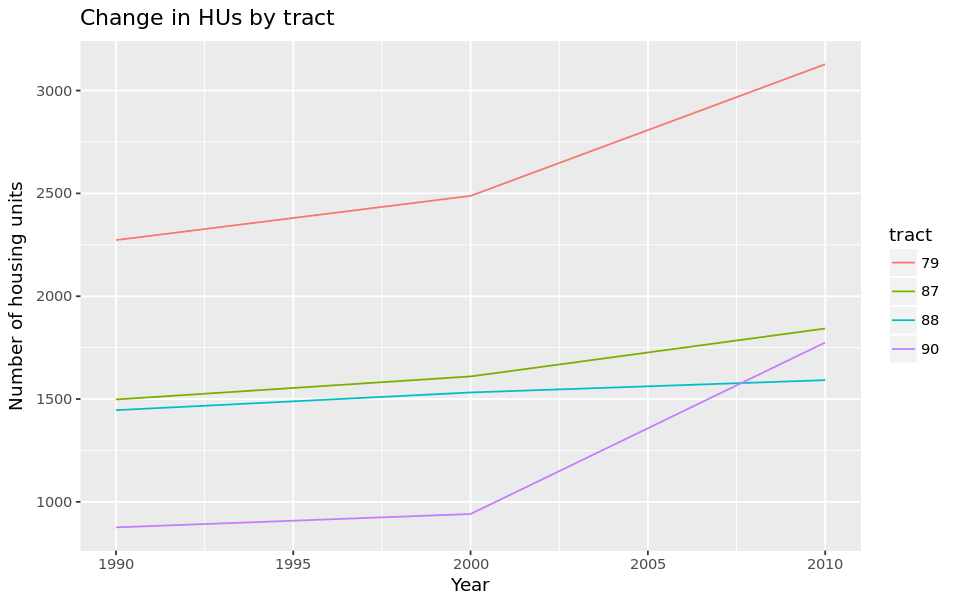

In [36]:
long_pull %>% filter(variable  == 'total_hu', geo == 'tract') %>%
    ggplot(aes(x = year, y = value, group = tract)) + 
    geom_line(aes(color = tract)) + labs(y = 'Number of housing units', x = "Year", title = "Change in HUs by tract")

Overall, all of the tracts are growing in terms of the number of households within them, with 79 and 90 showing the largest increase.

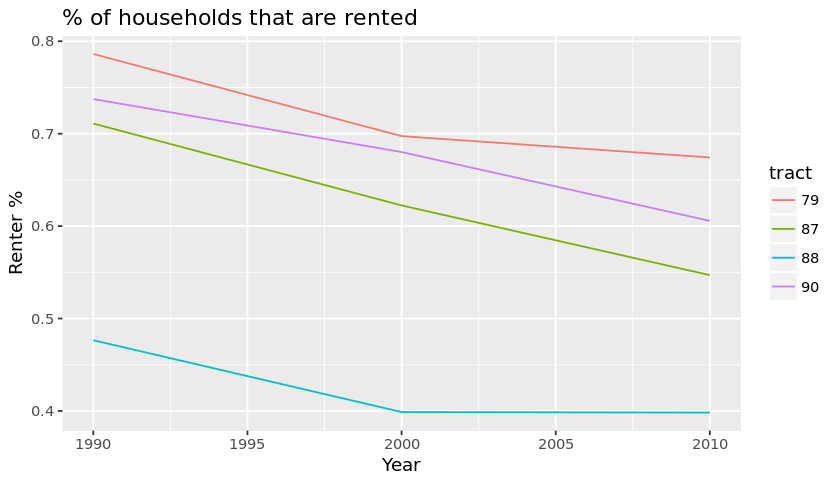

In [64]:
print(long_pull %>% filter(variable == 'rent_pcent', geo == 'tract') %>%
    ggplot(aes(x = year, y = value)) + geom_line(aes(color = tract, group = tract)) +
        labs(y = 'Renter %', x = 'Year',  title = '% of households that are rented'))

Interestingly, the proportion of households in the CD which are rented has been steadily decreasing. This suggests that the neighborhood was vulnerable to gentrification due to the fact that majority of households were able to be priced out due to rent increases. We'll investigate this further in a future blog post, which will be supplemented by ACS data, which includes housing costs. 

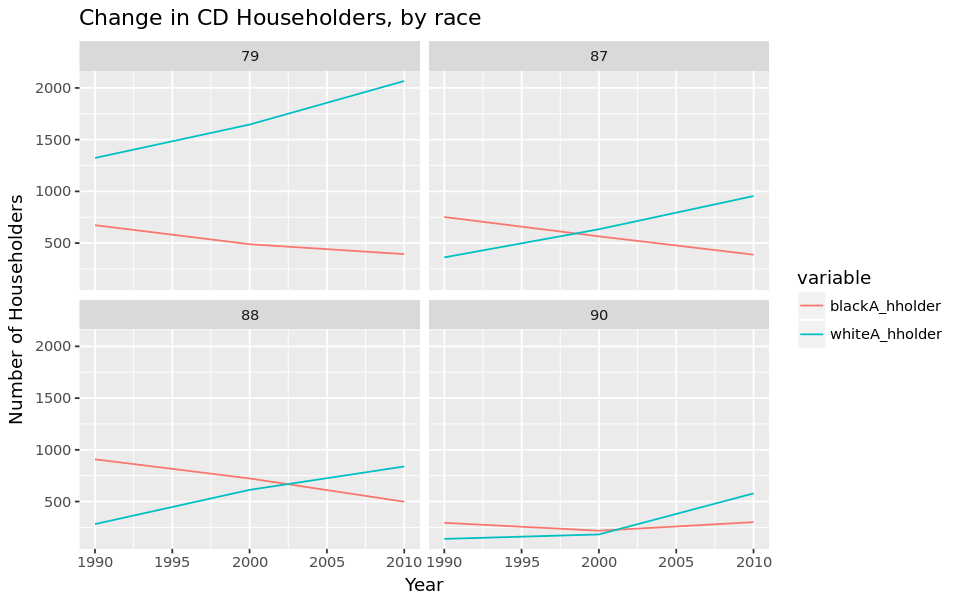

In [33]:
print(long_pull %>% filter(variable %in% c('blackA_hholder', 'whiteA_hholder'), geo == 'tract') %>%
                           ggplot(aes(x = year, y = value)) +
    geom_line(aes(color = variable, group = variable)) + 
      facet_wrap( ~ tract) + labs(y="Number of Householders", x = "Year", title = "Change in CD Householders, by race"))

However, despite the overall increase in the number of households in the CD, the number of black households is in steady decline. Thus, it is *not* the case that there are simply being more housing units built and are subsequently more likely to be occupied by a white householder. Instead, it is clear that there is an overall decline in the raw number of black households.

Next, let's look at the block group level, to answer the question: are black households being pushed inward and become more concentrated in any specific part of the CD?

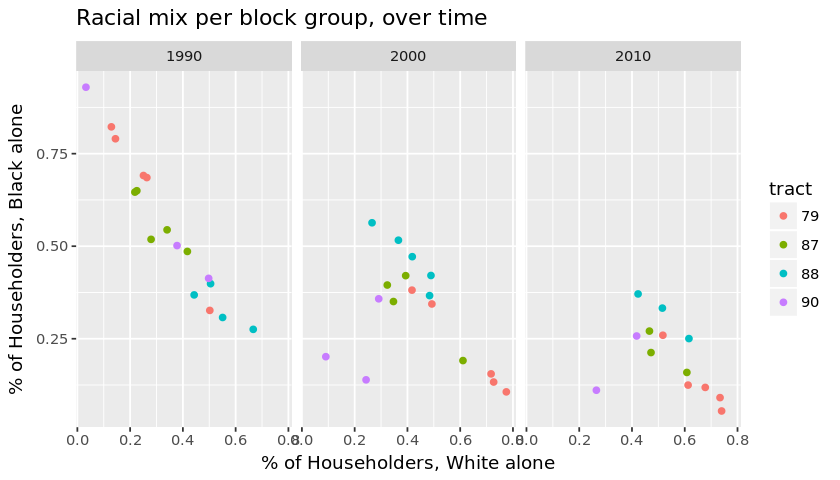

In [65]:
print(full_pull %>% filter(geo == 'blockgroup') %>% ggplot(aes(x = whiteA_pcent, y = blackA_pcent)) +
      geom_point(aes(color = tract)) + facet_grid(. ~ year) +
      labs(title = "Racial mix per block group, over time", x = '% of Householders, White alone', 
           y = '% of Householders, Black alone')
     ) 

No. Instead we see a striking pattern of decline, where around half the block groups in the CD were majority black in 1990, to just two in 2000 and zero in 2010. In fact, we note that block groups in tract 79, which had the highest density of black households in 1990, have the lowest in 2010.

Next, let's take a look at how these patterns have played out geographically. ggplot2 in the development branch now has the ability to manipulate sf objects and create charts of polygons with the shape of the tract or block group, which can be pulled down by specifying the ``geometry = TRUE`` parameter in the tidycensus call.

In [41]:
vars_2010_geom <- c('H0060002', 'H0060003')
pull_2010_geom <- get_decennial(year = 2010, variable = vars_2010_geom, 
                                state = 'WA', county = 'King', geography = 'block group',
                               geometry = TRUE, summary_var = 'H00010001') 
pull_2010_geom %<>% mutate(pcent = value/summary_value,
                           variable = fct_recode(variable, White = 'H0060002', Black = 'H0060003')) %>% 
            filter(GEOID %in% full_pull$geoid)

vars_2000_geom <- c('H006002', 'H006003')
pull_2000_geom <- get_decennial(year = 2000, variable = vars_2000_geom, 
                                state = 'WA', county = 'King', geography = 'block group',
                               geometry = TRUE, summary_var = 'H001001') 
pull_2000_geom %<>% mutate(pcent = value/summary_value,
                           variable = fct_recode(variable, White = 'H006002', Black = 'H006003')) %>% 
            filter(GEOID %in% full_pull$geoid)

vars_1990_geom <- c('H0080001', 'H0080002')
pull_1990_geom <- get_decennial(year = 1990, variable = vars_1990_geom, 
                                state = 'WA', county = 'King', geography = 'tract',
                               geometry = TRUE, summary_var = 'H0010001') 
pull_1990_geom %<>%  separate(NAME, into = c('tract', 'number'), sep = ' ') %>% 
filter(number %in% tracts) %>% 
mutate(pcent = value/summary_value, variable = fct_recode(variable, White = 'H0080001', Black = 'H0080002'))
            


Unfortunately, block-group-level geometry is not readily available, so we'll have to stick to tract-level resolution. The dilution and exodus of black households is evident. (Also shown is how the boundaries of the block groups change within each of the tracts). 

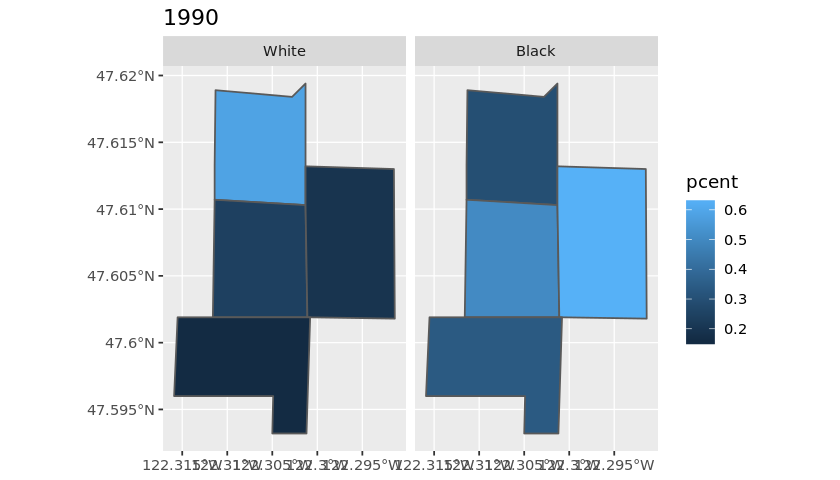

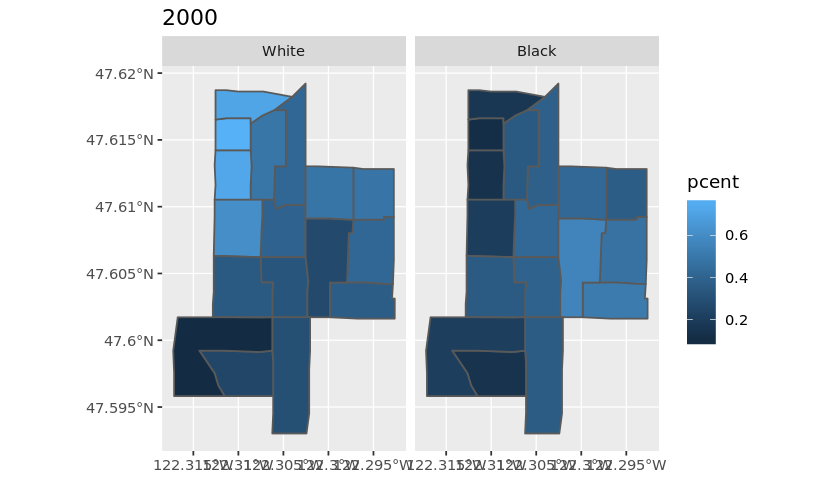

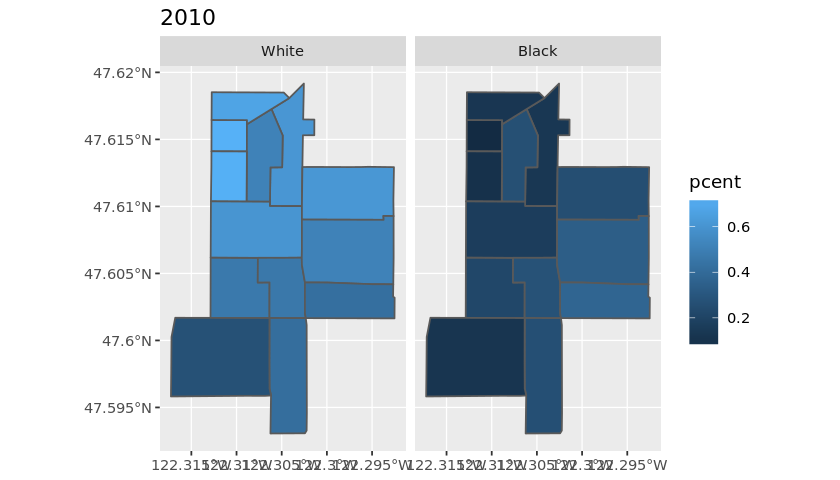

In [48]:
print(pull_1990_geom %>% ggplot(aes(fill = pcent), color = 'black') + facet_grid(. ~ variable) + geom_sf() + 
     labs(title = '1990'))

print(pull_2000_geom %>% ggplot(aes(fill = pcent), color = 'black') + facet_grid(. ~ variable) + geom_sf() + 
labs(title = '2000'))
print(pull_2010_geom %>% ggplot(aes(fill = pcent), color = 'black') + facet_grid(. ~ variable) + geom_sf() + 
    labs(title = '2010'))


This was certainly a wakeup call for me, as though I know about the current spate of gentrification affecting the CD, I had not realized the extent to which it had already been gentrified, from the 1990s onward. In a future blog post, we'll look at the factors that contributed to gentrification, and try to assess how much was due to each factor.